# Data Cleaning and Transformation

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Reading data
data = pd.read_csv('bank-full.csv', sep=';')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
# Numerical variables
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
# Exploring categorical variables
for col in data.select_dtypes(include='object').columns:
    print(col)
    print(data[col].unique())

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital
['married' 'single' 'divorced']
education
['tertiary' 'secondary' 'unknown' 'primary']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


## Finding missing values

In [10]:
# Finding missing values
features_na = [features for features in data.columns if data[features].isnull().sum() > 0]
for feature in features_na:
    print(feature, np.round(data[feature].isnull().mean(), 4),  ' % missing values')
else:
    print("No missing value found")

No missing value found


## Detecting Outliers

First, analyzing the boxplot of all the numerical variables to identify any potential outliers.

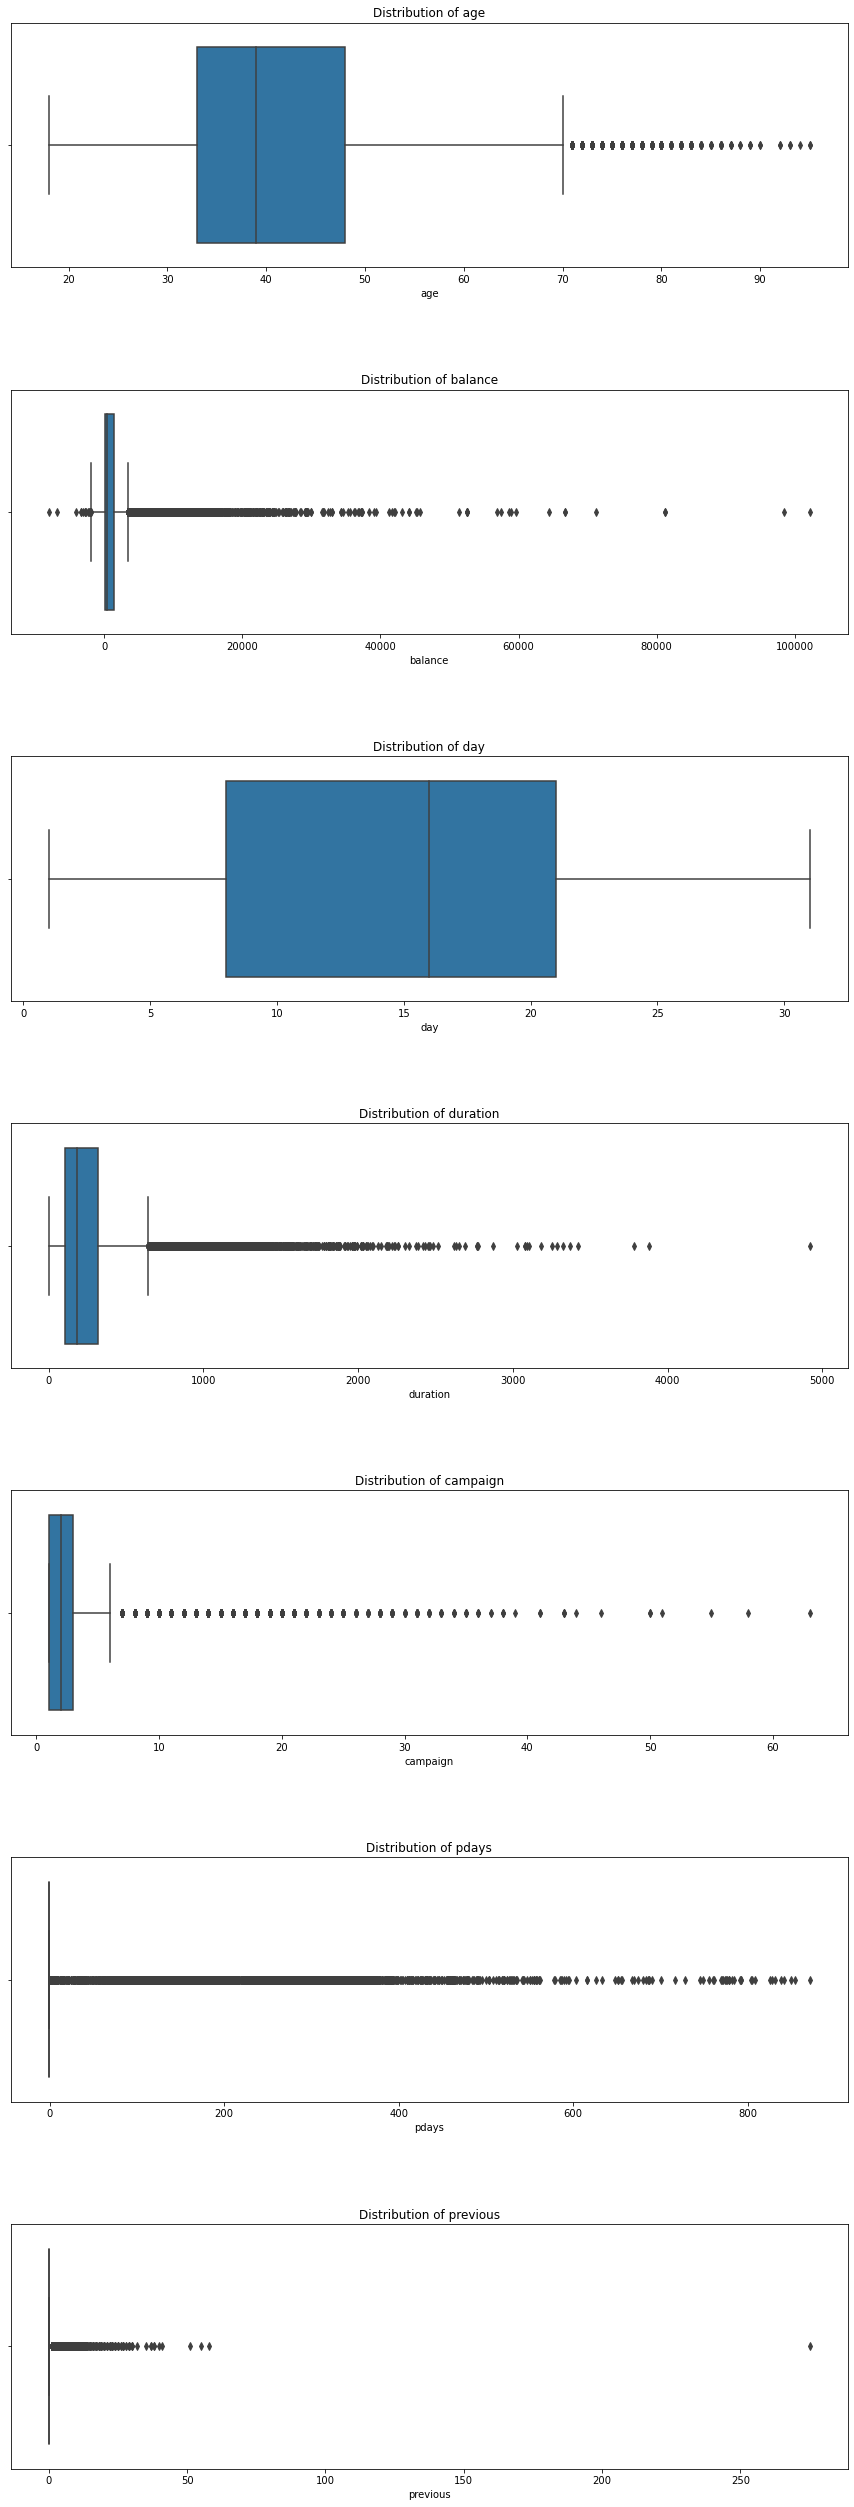

In [18]:
# distribution of numerical attributes
num_col = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'] # numeric columns

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 45)) # create subplots
fig.subplots_adjust(hspace=.5) # adjust space between plots

for i, col in enumerate(num_col):
    sns.boxplot(x=data[col], ax=ax[i])
    ax[i].set_title('Distribution of {}'.format(col))

So according to the boxplots above, the following variables are expected to have potential outliers:
`age`, `balance`, `duration`, `pdays`, `previous`, `campaign`. The Hampel correction rule is used here to identify outlier data.

In [23]:
def hampel_correction(col_name):
    
    stat_delivery = data[col_name].describe()
    
    #The median absolute deviation(MAD) scale estimator S = 1.4826 * median

    # median
    median = stat_delivery['50%']

    # mean absolute deviation
    S = 1.4826 * median

    # finding outliers using the hampel rule
    idx = data[abs(data[col_name] - median) > 3 * S].index

    return(idx, median)

In [26]:
for col in num_col:
    print('The number of outliers detected for ',col,' = ', len(hampel_correction(col)[0]))    

The number of outliers detected for  age  =  0
The number of outliers detected for  balance  =  7079
The number of outliers detected for  day  =  0
The number of outliers detected for  duration  =  1117
The number of outliers detected for  campaign  =  1196
The number of outliers detected for  pdays  =  45211
The number of outliers detected for  previous  =  8257


Replacing the outliers with the median and visualizing the boxplot of the new variables. 

In [28]:
for col in num_col:
    
    idx, median = hampel_correction(col)[0], hampel_correction(col)[1]
    
    data.loc[idx, col] = median    

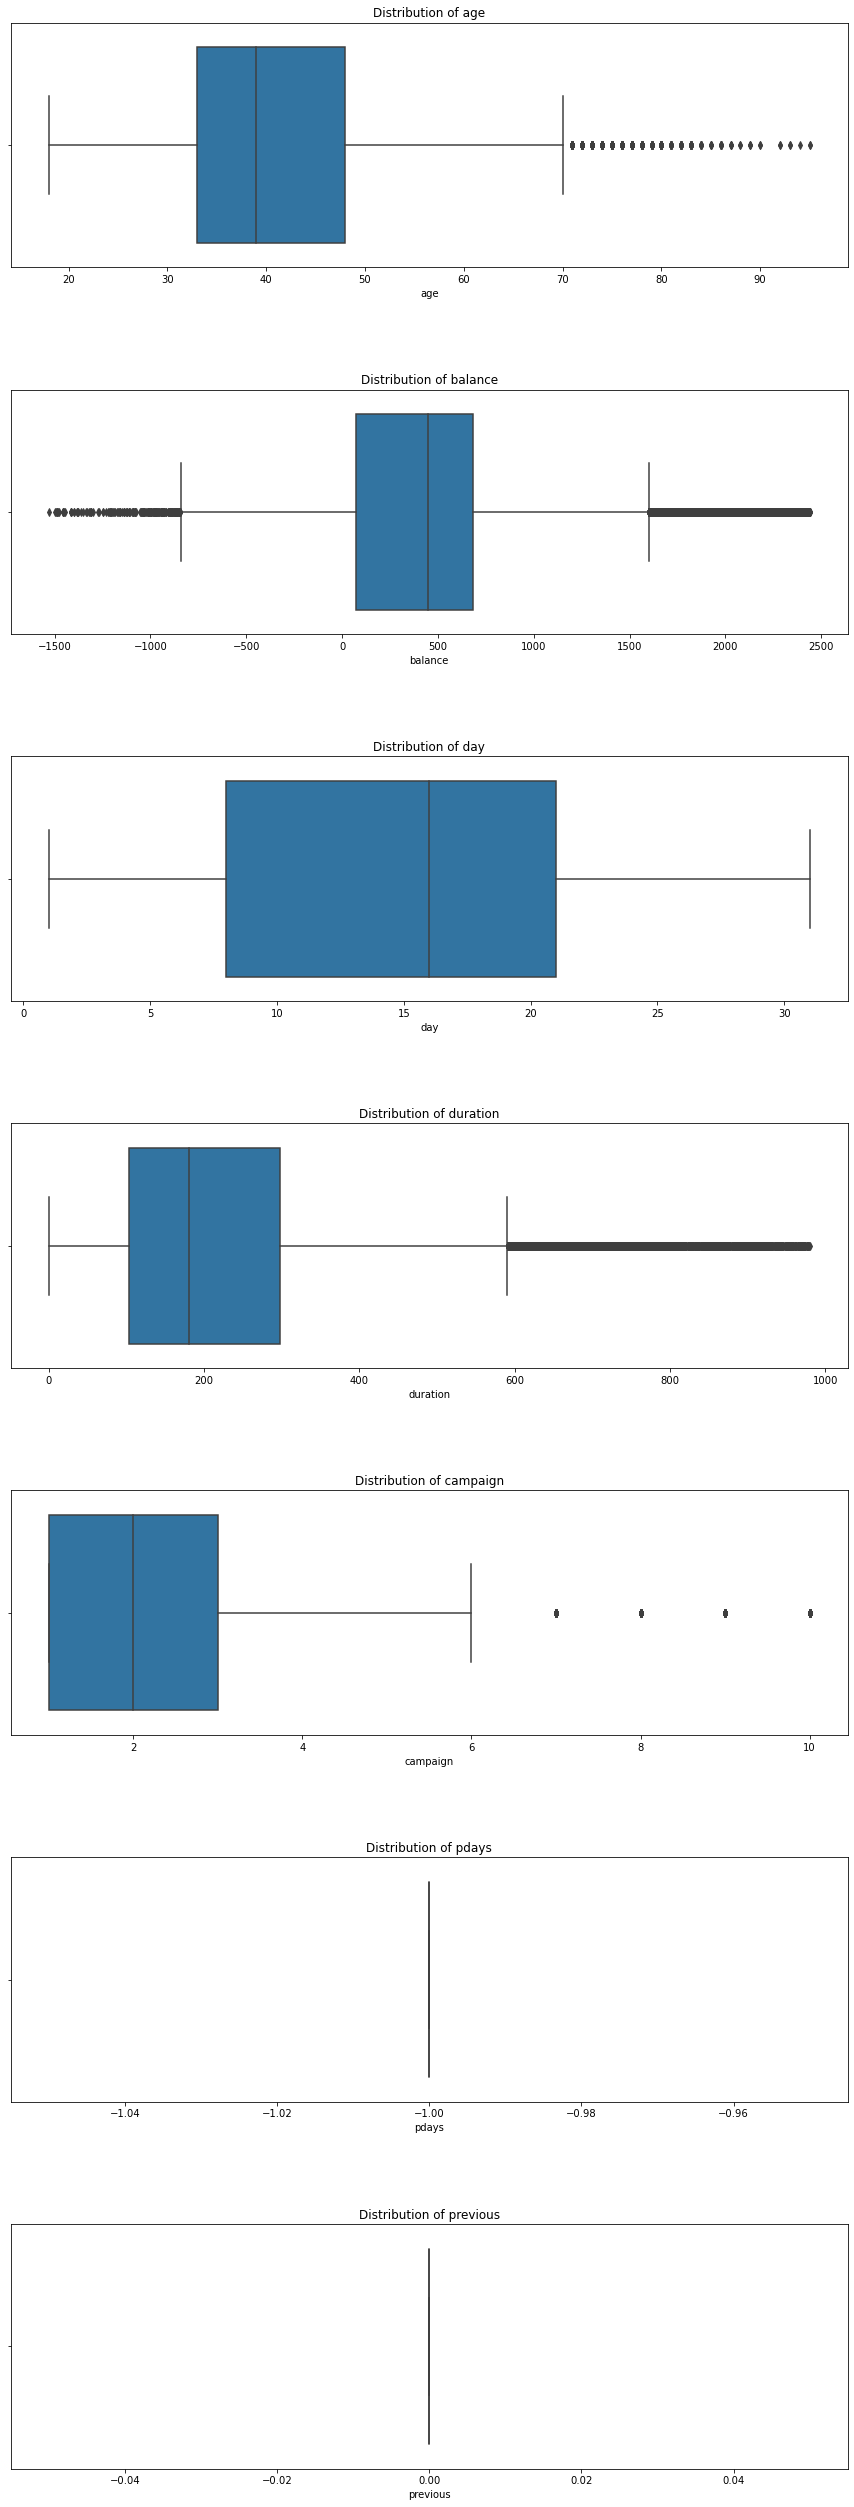

In [29]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 45)) # create subplots
fig.subplots_adjust(hspace=.5) # adjust space between plots

for i, col in enumerate(num_col):
    sns.boxplot(x=data[col], ax=ax[i])
    ax[i].set_title('Distribution of {}'.format(col))

Since this is a classification problem, looking at the distribution of the target variable.

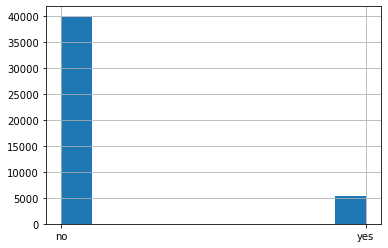

In [5]:
# Target variable
data.y.hist()

In [6]:
data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Clearly, there is a class imbalance with `no` being the majority class and `yes` being the minority class. 

## Solving for Class Imbalance 

Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class. 

Since the y variable is imbalanced towards the no responses, __over sampling__ has been used as a means of making the data balanced so that we have almost equal data with `no` and `yes` responses. 

Source: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [7]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [8]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable 
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', y.shape)
print('Resample dataset shape', y_ros.shape)

Original dataset shape (45211,)
Resample dataset shape (79844,)


In [9]:
y.value_counts()

y_ros.value_counts()

no     39922
yes    39922
Name: y, dtype: int64